# Day 1 · Notebook 04 — Semantic Segmentation with YOLOv8
We keep this notebook thin by leaning on the shared `cvcourse` helpers and a pretrained YOLOv8 segmentation head:
- Reuse the repo-aware path bootstrap so imports from `src/cvcourse` just work.
- Pull a sample image from `data/` and convert it to a tensor.
- Run the lightweight `yolov8n-seg` checkpoint, inspect the predicted masks, and visualize the best mask with our overlay utility.

In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import pandas as pd
import torch
from PIL import Image
from torchvision.transforms.functional import to_tensor

from huggingface_hub import hf_hub_download
from ultralytics import YOLO

ROOT = Path.cwd().resolve()
while not (ROOT / "pyproject.toml").exists() and ROOT != ROOT.parent:
    ROOT = ROOT.parent
if not (ROOT / "pyproject.toml").exists():
    raise FileNotFoundError("Could not locate repository root containing pyproject.toml")
SRC_DIR = ROOT / "src"
for path in (ROOT, SRC_DIR):
    if str(path) not in sys.path:
        sys.path.insert(0, str(path))

from cvcourse.utils.paths import get_data_dir
from cvcourse.viz.images import show_image
from cvcourse.viz.masks import overlay_mask

plt.style.use("ggplot")
torch.manual_seed(7)
torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

## 1. Resolve a sample image
The repo ships a `data/sample_image.jpeg` file so every student runs the same example. If it is missing, we fall back to the `ultralytics/assets` Hugging Face repo to keep the notebook reproducible.

Using shared sample at /Users/mishra/LM/projects/computer-vision-cas-hslu-2025/data/sample_image.jpeg


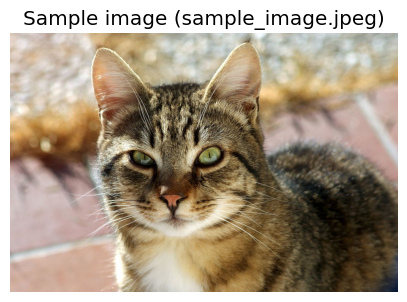

torch.Size([3, 803, 1200])

In [2]:
data_dir = get_data_dir()
sample_image_path = data_dir / "sample_image.jpeg"

if not sample_image_path.exists():
    print("Please add a sample image at data/sample_image.jpeg to proceed.")
else:
    print(f"Using shared sample at {sample_image_path}")

image = Image.open(sample_image_path).convert("RGB")
image_tensor = to_tensor(image)
show_image(image_tensor, title=f"Sample image ({sample_image_path.name})")
image_tensor.shape

## 2. Run YOLOv8 segmentation
`ultralytics.YOLO` takes care of downloading the pretrained checkpoint the first time it is requested. We request masks for the single image and collect the class predictions into a dataframe for quick inspection.

In [3]:
model = YOLO("yolov8n-seg.pt")
results = model(source=str(sample_image_path), imgsz=640, conf=0.35, verbose=False)
seg_result = results[0]

if seg_result.masks is None:
    raise RuntimeError("YOLOv8 did not return any masks for this image.")

boxes = seg_result.boxes
detections = []
for idx, (cls_id, conf) in enumerate(zip(boxes.cls.tolist(), boxes.conf.tolist())):
    label = seg_result.names[int(cls_id)]
    detections.append({
        "mask_idx": idx,
        "label": label,
        "confidence": float(conf),
    })

detections_df = pd.DataFrame(detections).sort_values("confidence", ascending=False).reset_index(drop=True)
detections_df

,mask_idx,label,confidence
0,0,cat,0.889921


## 3. Overlay the highest-confidence mask
We upsample the predicted mask to the original resolution, blend it with our helper, and display the result. Adjust `alpha` or swap `mask_idx` to compare different objects.

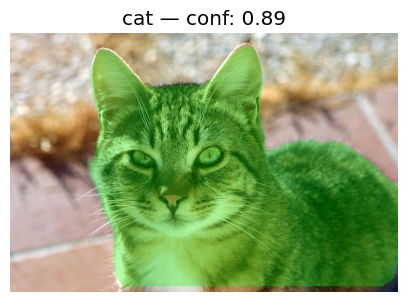

In [4]:
import torch.nn.functional as F

if detections_df.empty:
    raise ValueError("No detections available to visualize.")

best_row = detections_df.iloc[0]
mask_idx = int(best_row["mask_idx"])
mask = seg_result.masks.data[mask_idx]
mask_resized = F.interpolate(
    mask.unsqueeze(0).unsqueeze(0),
    size=image_tensor.shape[1:],
    mode="bilinear",
    align_corners=False
).squeeze()

overlay = overlay_mask(image_tensor, mask_resized, alpha=0.3, color=(0.0, 1.0, 0.0))
show_image(
    overlay,
    title=f"{best_row['label']} — conf: {best_row['confidence']:.2f}"
)

## 4. Next steps
- Swap in one of the images from `data/samples/coco128/images/train2017` and rerun the inference cell to compare masks.
- Iterate on `conf` or `imgsz` when a scene contains tiny objects.
- Combine this quick inference loop with the SAM helpers under `src/cvcourse/models/segmentation.py` for promptable segmentation demos.